In [1]:
!pip install lifelines
!wget https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%204/util.py

     |████████████████████████████████| 337kB 4.8MB/s 
--2020-06-15 14:17:55--  https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%204/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473 [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]     473  --.-KB/s    in 0s      

2020-06-15 14:17:55 (32.9 MB/s) - ‘util.py’ saved [473/473]



In [0]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

from util import load_data

In [7]:
!wget https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%204/pbc.csv

--2020-06-15 14:19:54--  https://raw.githubusercontent.com/ChanchalKumarMaji/AI-for-Medicine-Specialization-deeplearning.ai/master/AI%20for%20Medical%20Prognosis/Week%204/pbc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30823 (30K) [text/plain]
Saving to: ‘pbc.csv’

pbc.csv             100%[===================>]  30.10K  --.-KB/s    in 0.008s  

2020-06-15 14:19:55 (3.72 MB/s) - ‘pbc.csv’ saved [30823/30823]



In [0]:
df = load_data()

In [9]:
print(df.shape)
df.head()

(258, 19)


,time,status,trt,age,sex,ascites,hepato,spiders,edema,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,stage
0,1.095890,1.0,0.0,58.765229,0.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,12.328767,0.0,0.0,56.446270,0.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,2.772603,1.0,0.0,70.072553,1.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,5.273973,1.0,0.0,54.740589,0.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
6,5.019178,0.0,1.0,55.534565,0.0,0.0,1.0,0.0,0.0,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3.0


In [10]:
i = 20
df.iloc[i, :]

time          11.175342
status         1.000000
trt            0.000000
age           44.520192
sex            1.000000
ascites        0.000000
hepato         1.000000
spiders        0.000000
edema          0.000000
bili           2.100000
chol         456.000000
albumin        4.000000
copper       124.000000
alk.phos    5719.000000
ast          221.880000
trig         230.000000
platelet      70.000000
protime        9.900000
stage          2.000000
Name: 23, dtype: float64

In [11]:
np.random.seed(0)

df_dev, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_dev, test_size = 0.25)

print("Total number of patients:", df.shape[0])
print("Total number of patients in training set:", df_train.shape[0])
print("Total number of patients in validation set:", df_val.shape[0])
print("Total number of patients in test set:", df_test.shape[0])

Total number of patients: 258
Total number of patients in training set: 154
Total number of patients in validation set: 52
Total number of patients in test set: 52


In [0]:
def to_one_hot(dataframe, columns):

    one_hot_df = pd.get_dummies(dataframe, columns = columns, drop_first = True, dtype = np.float64)

    return one_hot_df

In [13]:
# list of categorical columns
to_encode = ['edema', 'stage']

one_hot_train = to_one_hot(df_train, to_encode)
one_hot_val = to_one_hot(df_val, to_encode)
one_hot_test = to_one_hot(df_test, to_encode)

print(one_hot_val.columns.tolist())
print(f"There are {len(one_hot_val.columns)} columns")

['time', 'status', 'trt', 'age', 'sex', 'ascites', 'hepato', 'spiders', 'bili', 'chol', 'albumin', 'copper', 'alk.phos', 'ast', 'trig', 'platelet', 'protime', 'edema_0.5', 'edema_1.0', 'stage_2.0', 'stage_3.0', 'stage_4.0']
There are 22 columns


In [14]:
print(one_hot_train.shape)
one_hot_train.head()

(154, 22)


,time,status,trt,age,sex,ascites,hepato,spiders,bili,chol,albumin,copper,alk.phos,ast,trig,platelet,protime,edema_0.5,edema_1.0,stage_2.0,stage_3.0,stage_4.0
279,3.868493,0.0,0.0,46.154689,0.0,0.0,0.0,0.0,1.6,325.0,3.69,69.0,2583.0,142.00,140.0,284.0,9.6,0.0,0.0,0.0,1.0,0.0
137,3.553425,1.0,0.0,51.249829,1.0,0.0,1.0,0.0,7.3,426.0,3.93,262.0,2424.0,145.70,218.0,252.0,10.5,0.0,0.0,0.0,1.0,0.0
249,4.846575,0.0,1.0,40.791239,0.0,0.0,1.0,0.0,0.6,299.0,3.36,23.0,2769.0,220.10,85.0,303.0,10.9,0.0,0.0,0.0,0.0,1.0
266,0.490411,1.0,0.0,70.907598,0.0,1.0,1.0,1.0,6.6,222.0,2.33,138.0,620.0,106.00,91.0,195.0,12.1,0.0,1.0,0.0,0.0,1.0
1,12.328767,0.0,0.0,56.446270,0.0,0.0,1.0,1.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0.0,0.0,0.0,1.0,0.0


In [15]:
cph = CoxPHFitter()
cph.fit(one_hot_train, duration_col = 'time', event_col = 'status', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 154 total observations, 90 right-censored observations>

In [16]:
cph.print_summary()

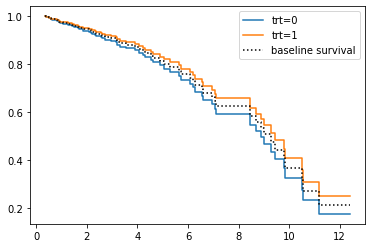

In [17]:
cph.plot_covariate_groups('trt', values=[0, 1]);

In [0]:
def hazard_ratio(case_1, case_2, cox_params):

    hr = np.exp(cox_params.dot((case_1 - case_2).T))

    return hr

In [19]:
i = 1
case_1 = one_hot_train.iloc[i, :].drop(['time', 'status'])

j = 5
case_2 = one_hot_train.iloc[j, :].drop(['time', 'status'])

print(hazard_ratio(case_1.values, case_2.values, cph.params_.values))

15.029017732492221


In [20]:
i = 4
case_a = one_hot_train.iloc[i, :].drop(['time', 'status'])

j = 7
case_b = one_hot_train.iloc[j, :].drop(['time', 'status'])

print("Case A\n\n", case_a, "\n")
print("Case B\n\n", case_b, "\n")
print("Hazard Ratio:", hazard_ratio(case_a.values, case_b.values, cph.params_.values))

Case A

 trt             0.00000
age            56.44627
sex             0.00000
ascites         0.00000
hepato          1.00000
spiders         1.00000
bili            1.10000
chol          302.00000
albumin         4.14000
copper         54.00000
alk.phos     7394.80000
ast           113.52000
trig           88.00000
platelet      221.00000
protime        10.60000
edema_0.5       0.00000
edema_1.0       0.00000
stage_2.0       0.00000
stage_3.0       1.00000
stage_4.0       0.00000
Name: 1, dtype: float64 

Case B

 trt             0.000000
age            55.392197
sex             0.000000
ascites         0.000000
hepato          1.000000
spiders         0.000000
bili            0.700000
chol          282.000000
albumin         3.000000
copper         52.000000
alk.phos     9066.800000
ast            72.240000
trig          111.000000
platelet      563.000000
protime        10.600000
edema_0.5       0.000000
edema_1.0       0.000000
stage_2.0       0.000000
stage_3.0       0.000000
s

In [0]:
def harrell_c(y_true, scores, event):

    n = len(y_true)
    assert (len(scores) == n and len(event) == n)

    concordant = 0.0
    permissible = 0.0
    ties = 0.0

    result = 0.0

    # use double for loop to go through cases
    for i in range(n):
        # set lower bound on j to avoid double counting
        for j in range(i+1, n):

            # check if at most one is censored
            if event[i] == 1 or event[j] == 1:
                # check if neither are censored
                if event[i] == 1 and event[j] == 1:
                    
                    permissible += 1.0

                    # check if scores are tied
                    if scores[i] == scores[j]:
                        ties += 1.0
                    # check for concordant
                    elif y_true[i] < y_true[j] and scores[i] > scores[j]:
                        concordant += 1.0
                    elif y_true[i] > y_true[j] and scores[i] < scores[j]:
                        concordant += 1.0
                
                # check if one is censored
                elif event[i] != event[j]:
                    # get censored index
                    censored = j
                    uncensored = i

                    if event[i] == 0:
                        censored = i
                        uncensored = j

                    # check if permissible
                    if y_true[uncensored] <= y_true[censored]:
                        # update ties
                        ties += 1.0
                    
                    # check if scores are concordant
                    if scores[uncensored] > scores[censored]:
                        concordant += 1.0
    
    # set result to c-index computed from number of concordant pairs,
    # number of ties, and number of permissible pairs
    result = (concordant + 0.5*ties) / permissible

    return result

In [22]:
y_true = [30, 12, 84, 9]

# Case 1
event = [1, 1, 1, 1]
scores = [0.5, 0.9, 0.1, 1.0]
print("Case 1")
print("Expected: 1.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 2
scores = [0.9, 0.5, 1.0, 0.1]
print("\nCase 2")
print("Expected: 0.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 3
event = [1, 0, 1, 1]
scores = [0.5, 0.9, 0.1, 1.0]
print("\nCase 3")
print("Expected: 1.0, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 4
y_true = [30, 30, 20, 20]
event = [1, 0, 1, 0]
scores = [10, 5, 15, 20]
print("\nCase 4")
print("Expected: 0.75, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 5
y_true = list(reversed([30, 30, 30, 20, 20]))
event = [0, 1, 0, 1, 0]
scores = list(reversed([15, 10, 5, 15, 20]))
print("\nCase 5")
print("Expected: 0.583, Output: {}".format(harrell_c(y_true, scores, event)))

# Case 6
y_true = [10,10]
event = [0,1]
scores = [4,5]
print("\nCase 6")
print(f"Expected: 1.0, Output: {harrell_c(y_true, scores, event):.4f}")

Case 1
Expected: 1.0, Output: 1.0

Case 2
Expected: 0.0, Output: 0.0

Case 3
Expected: 1.0, Output: 1.5

Case 4
Expected: 0.75, Output: 4.5

Case 5
Expected: 0.583, Output: 5.5

Case 6


ZeroDivisionError: ignored

In [23]:
# Train
scores = cph.predict_partial_hazard(one_hot_train)
cox_train_scores = harrell_c(one_hot_train['time'].values, scores.values, one_hot_train['status'].values)

# Validation
scores = cph.predict_partial_hazard(one_hot_val)
cox_val_scores = harrell_c(one_hot_val['time'].values, scores.values, one_hot_val['status'].values)

# Test 
scores = cph.predict_partial_hazard(one_hot_test)
cox_test_scores = harrell_c(one_hot_test['time'].values, scores.values, one_hot_test['status'].values)

print("Train:", cox_train_scores)
print("Val:", cox_val_scores)
print("Test:", cox_test_scores)

Train: 4.086805555555555
Val: 3.7246376811594204
Test: 4.063241106719367


In [0]:
%load_ext rpy2.ipython
%R require(ggplot2)

import rpy2
from rpy2.robjects.packages import importr

# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

rpy2.robjects.r('install.packages("randomForestSRC")')
forest = rpackages.importr('randomForestSRC', lib_loc='R')

from rpy2 import robjects as ro
R = ro.r

from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [0]:
model = forest.rfsrc(ro.Formula('Surv(time, status) ~ .'), data=df_train, ntree=300, nodedepth=5, seed=-1)

In [33]:
print(model)

                         Sample size: 154
                    Number of deaths: 64
                     Number of trees: 300
           Forest terminal node size: 15
       Average no. of terminal nodes: 6.54
No. of variables tried at each split: 5
              Total no. of variables: 17
       Resampling used to grow trees: swor
    Resample size used to grow trees: 97
                            Analysis: RSF
                              Family: surv
                      Splitting rule: logrank *random*
       Number of random split points: 10
                          Error rate: 19.07%




In [34]:
result = R.predict(model, newdata=df_val)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Validation Score:", cox_val_scores)
print("Survival Forest Validation Score:", harrell_c(df_val['time'].values, scores, df_val['status'].values))

Cox Model Validation Score: 3.7246376811594204
Survival Forest Validation Score: 3.6666666666666665


In [35]:
result = R.predict(model, newdata=df_test)
scores = np.array(result.rx('predicted')[0])

print("Cox Model Test Score:", cox_test_scores)
print("Survival Forest Validation Score:", harrell_c(df_val['time'].values, scores, df_test['status'].values))

Cox Model Test Score: 4.063241106719367
Survival Forest Validation Score: 3.4486166007905137


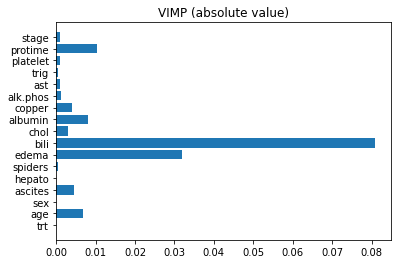

In [36]:
vimps = np.array(forest.vimp(model).rx('importance')[0])

y = np.arange(len(vimps))

plt.barh(y, np.abs(vimps))
plt.yticks(y, df_train.drop(['time', 'status'], axis=1).columns)
plt.title("VIMP (absolute value)")
plt.show()